In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import matplotlib.pyplot as plt

import numpy as np
import scipy.sparse as sp
import pickle
import pandas as pd
import torch_scatter
from collections import Counter


from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import MD17
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GAT



In [10]:
import torch_geometric.transforms as T

max_nodes = 150
class MyFilter(object):
    def __call__(self, data):
        return data.num_nodes <= max_nodes

    
dataset_directory = '/notebooks/data'
# dataset = MD17(root=dataset_directory, name='benzene', transform=T.Compose([T.RadiusGraph(1e2), T.Distance(), T.ToDense()]))
dataset = MD17(root=dataset_directory, name='benzene', transform=T.Compose([T.RadiusGraph(1e2), T.Distance()]))
dataset[0]

Processing...
Done!


Data(pos=[12, 3], z=[12], energy=[1], force=[12, 3], edge_index=[2, 132], edge_attr=[132, 1])

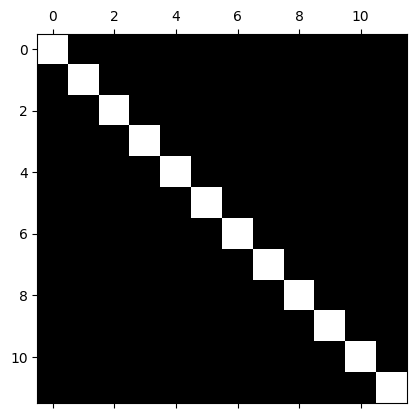

In [8]:
plt.spy(np.matrix(dataset[0].adj.numpy())

In [2]:
import os.path as osp

import torch
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])
path = '/notebooks/data'
dataset = Planetoid(path, name='Cora', transform=transform)
# After applying the `RandomLinkSplit` transform, the data is transformed from
# a data object to a list of tuples (train_data, val_data, test_data), with
# each element representing the corresponding split.
train_data, val_data, test_data = dataset[0]


In [3]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()


model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()




In [4]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())




In [5]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Epoch: 001, Loss: 0.6930, Val: 0.6881, Test: 0.6653
Epoch: 002, Loss: 0.6815, Val: 0.6810, Test: 0.6622
Epoch: 003, Loss: 0.7114, Val: 0.6844, Test: 0.6648
Epoch: 004, Loss: 0.6772, Val: 0.6949, Test: 0.6695
Epoch: 005, Loss: 0.6846, Val: 0.7068, Test: 0.6780
Epoch: 006, Loss: 0.6887, Val: 0.7341, Test: 0.6947
Epoch: 007, Loss: 0.6899, Val: 0.7373, Test: 0.6950
Epoch: 008, Loss: 0.6897, Val: 0.7258, Test: 0.6832
Epoch: 009, Loss: 0.6879, Val: 0.7189, Test: 0.6741
Epoch: 010, Loss: 0.6843, Val: 0.7077, Test: 0.6677
Epoch: 011, Loss: 0.6788, Val: 0.6954, Test: 0.6602
Epoch: 012, Loss: 0.6752, Val: 0.6877, Test: 0.6547
Epoch: 013, Loss: 0.6739, Val: 0.6879, Test: 0.6555
Epoch: 014, Loss: 0.6704, Val: 0.7085, Test: 0.6744
Epoch: 015, Loss: 0.6608, Val: 0.7381, Test: 0.7066
Epoch: 016, Loss: 0.6563, Val: 0.7512, Test: 0.7210
Epoch: 017, Loss: 0.6487, Val: 0.7485, Test: 0.7195
Epoch: 018, Loss: 0.6368, Val: 0.7467, Test: 0.7171
Epoch: 019, Loss: 0.6244, Val: 0.7622, Test: 0.7362
Epoch: 020, 